# Exploring the Targets of UN Sustainable Development Goals
## Data preprocessing and visualisation

In this notebook, we preprocess and visualise data of the *targets* of [United Nations Sustainable Development Goals](https://sustainabledevelopment.un.org/?menu=1300). For each of these targets, at least one quantitatively measurable *indicator* is defined. The total number of targets is 169; of those, data for 83 are given by the [UN Statistics Division](https://unstats.un.org/sdgs/indicators/database/).

### Research questions:
1. How are the observable targets interrelated?
2. How is a change in one target influential to another target? E.g., has a rise in GDP any influence on the decrease of poverty?

### Import the required packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import pystan_utils
import os

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

### Use pandas to load the data set

In [2]:
# load csv
df = pd.read_csv("SDG_Indicators.csv")
df.head()

,Goal,Target,Indicator Ref,IndicatorId,Indicator Description,Series Code,Series Type,Series Description,Parent Country or Area Code,Country or Area Code,...,2013,FN.30,2014,FN.31,2015,FN.32,2016,FN.33,2017,FN.34
0,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_DAY1,SD,Proportion of population below the internation...,NaN,MDG_WORLD,...,10.70,"24, 70",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_EMP1,SD,Proportion of employed population below the in...,NaN,MDG_WORLD,...,16.45,"M, 24, 72",15.87,"M, 25, 72",15.51,"M, 26, 72",15.10,"M, 27, 72",NaN,NaN
2,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_EMP1,SD,Proportion of employed population below the in...,NaN,MDG_WORLD,...,16.37,"M, 24, 72",15.83,"M, 25, 72",15.54,"M, 26, 72",15.18,"M, 27, 72",NaN,NaN
3,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_EMP1,SD,Proportion of employed population below the in...,NaN,MDG_WORLD,...,16.50,"M, 24, 72",15.89,"M, 25, 72",15.49,"M, 26, 72",15.04,"M, 27, 72",NaN,NaN
4,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_EMP1,SD,Proportion of employed population below the in...,NaN,MDG_WORLD,...,11.14,"M, 24, 72",10.61,"M, 25, 72",10.25,"M, 26, 72",9.87,"M, 27, 72",NaN,NaN


### Modify df to focus on columns of use

Display columns

In [3]:
df.columns

Index(['Goal', 'Target', 'Indicator Ref', 'IndicatorId',
       'Indicator Description', 'Series Code', 'Series Type',
       'Series Description', 'Parent Country or Area Code',
       'Country or Area Code', 'Country or Area Name', 'LDC', 'LLDC', 'SIDS',
       'Frequency', 'Source type', 'Age group', 'Location', 'Sex',
       'Value type', 'Unit', 'Unit multiplier', '1983', 'FN', '1984', 'FN.1',
       '1985', 'FN.2', '1986', 'FN.3', '1987', 'FN.4', '1988', 'FN.5', '1989',
       'FN.6', '1990', 'FN.7', '1991', 'FN.8', '1992', 'FN.9', '1993', 'FN.10',
       '1994', 'FN.11', '1995', 'FN.12', '1996', 'FN.13', '1997', 'FN.14',
       '1998', 'FN.15', '1999', 'FN.16', '2000', 'FN.17', '2001', 'FN.18',
       '2002', 'FN.19', '2003', 'FN.20', '2004', 'FN.21', '2005', 'FN.22',
       '2006', 'FN.23', '2007', 'FN.24', '2008', 'FN.25', '2009', 'FN.26',
       '2010', 'FN.27', '2011', 'FN.28', '2012', 'FN.29', '2013', 'FN.30',
       '2014', 'FN.31', '2015', 'FN.32', '2016', 'FN.33', '2017'

Delete the columns of no use.
Decided to drop all years before 2005 as they only have very few data points.

In [4]:
df1 = df.drop(['IndicatorId', 'Series Code', 'Series Type',
             'Series Description', 'Parent Country or Area Code',
             'Country or Area Code', 'Country or Area Name', 'LDC', 'LLDC', 'SIDS',
             'Frequency', 'Source type', 'Location', 'Value type', '1983', 'FN', '1984', 'FN.1',
               '1985', 'FN.2', '1986', 'FN.3', '1987', 'FN.4', '1988', 'FN.5', '1989',
               'FN.6', '1990', 'FN.7', '1991', 'FN.8', '1992', 'FN.9', '1993', 'FN.10',
               '1994', 'FN.11', '1995', 'FN.12', '1996', 'FN.13', '1997', 'FN.14',
               '1998', 'FN.15', '1999', 'FN.16', '2000', 'FN.17', '2001', 'FN.18',
               '2002', 'FN.19', '2003', 'FN.20', '2004', 'FN.21','FN.22','FN.23','FN.24',
               'FN.25','FN.26','FN.27','FN.28','FN.29','FN.30','FN.31','FN.32','FN.33','FN.34',
              ], axis=1)

In [5]:
df1.head()

,Goal,Target,Indicator Ref,Indicator Description,Age group,Sex,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,1.1,1.1.1,Proportion of population below the internation...,All age ranges or no breakdown by age,Both sexes or no breakdown by sex,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN
1,1,1.1,1.1.1,Proportion of population below the internation...,15 to 24 years old,Both sexes or no breakdown by sex,Percent,Units,24.80,23.86,...,22.04,21.18,20.22,18.26,17.08,16.45,15.87,15.51,15.10,NaN
2,1,1.1,1.1.1,Proportion of population below the internation...,15 to 24 years old,Female,Percent,Units,24.82,23.87,...,21.83,20.84,19.84,18.04,16.98,16.37,15.83,15.54,15.18,NaN
3,1,1.1,1.1.1,Proportion of population below the internation...,15 to 24 years old,Male,Percent,Units,24.78,23.86,...,22.18,21.41,20.47,18.40,17.15,16.50,15.89,15.49,15.04,NaN
4,1,1.1,1.1.1,Proportion of population below the internation...,15 years old and over,Both sexes or no breakdown by sex,Percent,Units,18.69,17.97,...,16.35,15.51,14.62,12.89,11.77,11.14,10.61,10.25,9.87,NaN


In [6]:
# proof which columns are remaining
df1.columns

Index(['Goal', 'Target', 'Indicator Ref', 'Indicator Description', 'Age group',
       'Sex', 'Unit', 'Unit multiplier', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

#### what do these columns express?

- 'Goal': defining the overall goal
- 'Target': measurable target
- 'Indicator Ref': number of the indicator, e.g. 1.1.1  
- year indicating in which year the measure was taken
- 'Age group'
- 'Sex'
- 'Unit'
- 'Unit multiplier'
- 'Indicator Description': description of the indicator

#### Select the rows that display data of importance
    
Rows: we want data of *all* age groups and sex
    

In [7]:
# Rows
# all age groups
df2 = df1[df1['Age group'].isin(['All age ranges or no breakdown by age'])]
df3 = df2.drop(['Age group'], axis=1)

# all sex
df4 = df3[df3['Sex'].isin(['Both sexes or no breakdown by sex'])]
df5 = df4.drop(['Sex'], axis=1)

# delete rows with no data
df6 = df5[~df5.isnull()]
df6

,Goal,Target,Indicator Ref,Indicator Description,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,1.1,1.1.1,Proportion of population below the internation...,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN
10,1,1.3,1.3.1,Proportion of population covered by social pro...,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
11,1,1.3,1.3.1,Proportion of population covered by social pro...,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
12,1,1.3,1.3.1,Proportion of population covered by social pro...,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
13,1,1.3,1.3.1,Proportion of population covered by social pro...,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN
14,1,1.3,1.3.1,Proportion of population covered by social pro...,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.93,NaN
15,1,1.3,1.3.1,Proportion of population covered by social pro...,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.77,NaN
16,1,1.3,1.3.1,Proportion of population covered by social pro...,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72,NaN
17,2,2.1,2.1.1,Prevalence of undernourishment,Percent,Units,14.70,14.30,13.70,13.00,12.50,12.10,11.80,11.40,11.20,11.00,10.80,NaN,NaN
48,2,2.5,2.5.1,Number of plant and animal genetic resources f...,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"11,616.00",NaN,NaN,NaN,NaN


In [8]:
# show all units
units = df6.Unit.unique()
for u in units:
    print(u)
    print(df6[df6['Unit'].isin([u])]['Indicator Description'].unique())
    print('------------------------------------------------------------------------------------')

Percent
['Proportion of population below the international poverty line, by sex, age, employment status and geographical location (urban/rural)'
 'Proportion of population covered by social protection floors/systems, by sex, distinguishing children, unemployed persons, older persons, persons with disabilities, pregnant women, newborns, work-injury victims and the poor and the vulnerable'
 'Prevalence of undernourishment'
 'Number of plant and animal genetic resources for food and agriculture secured in either medium or long-term conservation facilities'
 'Proportion of local breeds classified as being at risk, not-at-risk or at unknown level of risk of extinction'
 'Proportion of births attended by skilled health personnel'
 'Participation rate in organized learning (one year before the official primary entry age), by sex'
 'Proportion of population using safely managed drinking water services'
 'Proportion of population using safely managed sanitation services, including a hand-washin

# Create Dataframes of different categories

We created by hand an Excel sheet in which we labeled targets to three major categories. These categories are:
1. Population
2. Economy & Politics (E&P)
3. Environment

Units in each category are very different; we conform the units in each category according to the subsequent table.


| Category      | Unit             |
|---------------|------------------|
|Population     | Percent          |
|E&P            | Percent & USD    |
|Environment    | Percent & Tonnes |

In [9]:
# import Excel sheet
indicator_categories = pd.read_csv('Dev_Indicators.csv', delimiter=';')
del indicator_categories['Unnamed: 2']
del indicator_categories['Unnamed: 3']
indicator_categories.head()

,Category,Indicator Description
0,----,"Number of verified cases of killing, kidnappin..."
1,E&P (Percent),Number of countries that have national statist...
2,E&P (Percent),Number of countries with a national statistica...
3,E&P (Percent),Energy intensity measured in terms of primary ...
4,E&P (Percent),Annual growth rate of real GDP per capita


In [10]:
# get a quick overview
df6['Indicator Description']

0      Proportion of population below the internation...
10     Proportion of population covered by social pro...
11     Proportion of population covered by social pro...
12     Proportion of population covered by social pro...
13     Proportion of population covered by social pro...
14     Proportion of population covered by social pro...
15     Proportion of population covered by social pro...
16     Proportion of population covered by social pro...
17                        Prevalence of undernourishment
48     Number of plant and animal genetic resources f...
49     Number of plant and animal genetic resources f...
50     Number of plant and animal genetic resources f...
51     Number of plant and animal genetic resources f...
52     Number of plant and animal genetic resources f...
53     Number of plant and animal genetic resources f...
54     Number of plant and animal genetic resources f...
55     Proportion of local breeds classified as being...
56     Proportion of local bree

Our Excel sheet and df6 have the same indicator descriptions, which is the reason to perform the merge on this column.

In [11]:
ind_cat_joined = indicator_categories.merge(df6, on='Indicator Description')
ind_cat_joined.head()

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,----,"Number of verified cases of killing, kidnappin...",16,16.10,16.10.1,Number,Units,NaN,NaN,NaN,NaN,NaN,65.00,62.00,124.00,90.00,98.00,115.00,102.00,NaN
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.00,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,NaN


Another little clean up

In [12]:
# delete rows with '----' and '---'
ind_cat_joined_1 = ind_cat_joined[ind_cat_joined.Category != '----']
ind_cat_joined_2 = ind_cat_joined_1[ind_cat_joined_1.Category != '---']
ind_cat_joined_2

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.00,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,NaN
5,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.00,NaN
6,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.00,NaN
7,E&P (Percent),Energy intensity measured in terms of primary ...,7,7.3,7.3.1,Megajoules per USD constant 2011 PPP GDP,Units,6.37,NaN,NaN,NaN,NaN,5.95,NaN,NaN,NaN,5.49,NaN,NaN,NaN
8,E&P (Percent),Annual growth rate of real GDP per capita,8,8.1,8.1.1,Percent,Units,2.35,2.77,2.61,0.20,-3.24,2.82,1.62,1.01,1.08,1.35,1.45,NaN,NaN
9,E&P (Percent),Annual growth rate of real GDP per employed pe...,8,8.2,8.2.1,Percent,Units,2.77,3.85,3.79,1.83,-0.71,4.07,2.66,1.90,1.93,1.80,1.67,1.80,NaN
10,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,Percent,Units,15.28,15.61,15.84,15.74,14.99,15.81,15.97,15.94,15.99,16.03,16.11,16.16,NaN


In [13]:
ind_cat_joined_2['Category'].unique()

array(['E&P (Percent)', 'E&P (percent)', 'E&P (USD)',
       'Environment (Percent)', 'Environment (percent)',
       'Environment (Tonnes)', 'Population', 'Population (Percent)'],
      dtype=object)

## Population dataframe

The first category we would like to visualise data for is "Population"

In [14]:
# with what kind of units do we have to deal?
df_population = ind_cat_joined_2[ind_cat_joined_2['Category'].str.contains('Population')]
df_population['Unit'].unique()

array(['Percent', 'Per 100,000 live births',
       'Per 1,000 uninfected population', 'Per 100,000 population',
       'Per 1,000 population', 'Number', 'Per million population'],
      dtype=object)

As we stated previously, we agreed on using 'Percent' as the unit for this category. With the information of the previous cell, we can see that 'Number' is the only unit not easily convertable into 'Percent'.

In [15]:
df_population[df_population['Unit'].str.contains('Number')]['Indicator Description'].unique()

array(['Suicide mortality rate',
       'Degree of integrated water resources management implementation (0-100)',
       'Number of victims of intentional homicide per 100,000 population, by sex and age'],
      dtype=object)

In [16]:
# see the number value for suicide mortality rate
df_population[df_population['Indicator Description'].str.contains('Suicide mortality rate')]

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
121,Population,Suicide mortality rate,3,3.4,3.4.2,"Per 100,000 population",Units,11.61,NaN,NaN,NaN,NaN,11.23,NaN,NaN,NaN,NaN,10.73,NaN,NaN
122,Population,Suicide mortality rate,3,3.4,3.4.2,Number,Thousands,756.72,NaN,NaN,NaN,NaN,777.95,NaN,NaN,NaN,NaN,788.09,NaN,NaN


In [17]:
year = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017']

In [18]:
def popToPercent(unit, n):
    if type(n)==float:
        n2 = n
    elif n.find(',') != -1:
        n = n.replace(',','')
    n2 = float(n)
    if np.isnan(n2):
        return np.nan
    if unit =='Percent':
        return n2
    if unit == 'Per 1,000 population' or 'Per 1,000 uninfected population':
        return n2/10
    if unit == 'Per 100,000 population':
        return n2/1000

In [19]:
df_pop_soon_percent = df_population[~df_population['Unit'].isin(['Number'])]

In [20]:
df_pop_to_percent = df_pop_soon_percent.copy()
for yr in year:
    #df_pop_to_percent[yr] = df_pop_to_percent.apply(lambda r: r[yr].replace(',',''), axis=1)
    df_pop_to_percent[yr] = df_pop_to_percent.apply(lambda r: popToPercent(r['Unit'], r[yr]), axis=1)
df_pop_to_percent['Unit'] = 'Percent'
df_pop_to_percent

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.700,NaN,NaN,NaN,NaN
107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN
111,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.93,NaN
112,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.77,NaN
113,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72,NaN
114,Population,Maternal mortality ratio,3,3.1,3.1.1,Percent,Units,28.800,NaN,NaN,NaN,NaN,24.600,NaN,NaN,NaN,NaN,21.600,NaN,NaN
115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,NaN,NaN,NaN,69.880,NaN,NaN,NaN,NaN,NaN,78.49,NaN


In [21]:
#note: All the ones that are covered here, are already expressed in other units, s.a. percent or per 100,000 population, so we can just ignore these values

df_pop_number = df_population[df_population['Unit'].isin(['Number'])]
df_pop_number = df_pop_number[~df_pop_number['Indicator Description'].str.contains('Suicide mortality rate')] # got that covered

df_pop_number.head()

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
141,Population,Degree of integrated water resources managemen...,6,6.5,6.5.1,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.00,NaN,NaN,NaN,NaN,NaN
143,Population,Degree of integrated water resources managemen...,6,6.5,6.5.1,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.00,NaN,NaN,NaN,NaN,NaN
144,Population,Degree of integrated water resources managemen...,6,6.5,6.5.1,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.00,NaN,NaN,NaN,NaN,NaN
146,Population,Degree of integrated water resources managemen...,6,6.5,6.5.1,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN,NaN
148,Population,Degree of integrated water resources managemen...,6,6.5,6.5.1,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.00,NaN,NaN,NaN,NaN,NaN


In [22]:
# to recap with which data set we'll make the plots
df_pop_to_percent

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.700,NaN,NaN,NaN,NaN
107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN
111,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.93,NaN
112,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.77,NaN
113,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72,NaN
114,Population,Maternal mortality ratio,3,3.1,3.1.1,Percent,Units,28.800,NaN,NaN,NaN,NaN,24.600,NaN,NaN,NaN,NaN,21.600,NaN,NaN
115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,NaN,NaN,NaN,69.880,NaN,NaN,NaN,NaN,NaN,78.49,NaN


## Plot the category 'Population'

We have data available for several years, but in the plot is only data contained of the last measurements.

In [23]:
# convert all NaN to zero
df_pop_to_percent.fillna(0, inplace=True)
df_pop_to_percent.head()

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,0.0,0.0,0.00,0.0
107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.17,0.0
108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.86,0.0
109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.79,0.0
110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.08,0.0


In [31]:
def getlatestValue(row):
    for y in year[::-1]:
        if row[y] != 0:
            return row[y]

In [32]:
df_pop_to_percent['latest Value'] = df_pop_to_percent.apply(getlatestValue, axis=1)
df_pop_to_percent

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,latest Value
106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,10.700,0.000,0.000,0.00,0.00,10.700
107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,45.17,0.00,45.170
108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,34.86,0.00,34.860
109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,27.79,0.00,27.790
110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,41.08,0.00,41.080
111,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,67.93,0.00,67.930
112,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,21.77,0.00,21.770
113,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,24.72,0.00,24.720
114,Population,Maternal mortality ratio,3,3.1,3.1.1,Percent,Units,28.800,0.000,0.000,...,0.000,24.600,0.000,0.000,0.000,0.000,21.600,0.00,0.00,21.600
115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,0.000,0.000,0.000,...,0.000,69.880,0.000,0.000,0.000,0.000,0.000,78.49,0.00,78.490


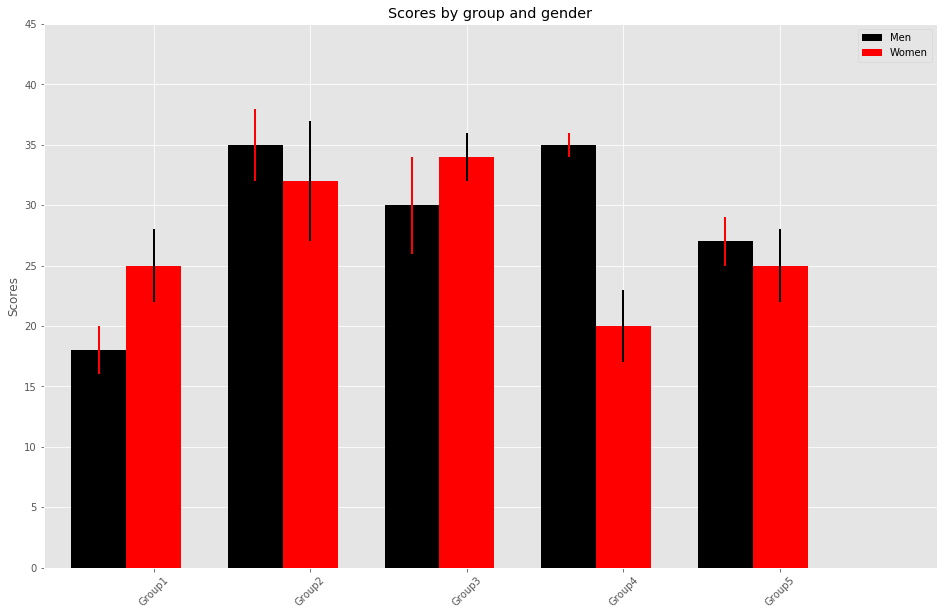

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

N=5
## the data
menMeans = [18, 35, 30, 35, 27]
menStd =   [2, 3, 4, 1, 2]
womenMeans = [25, 32, 34, 20, 25]
womenStd =   [3, 5, 2, 3, 3]

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, menMeans, width,
                color='black',
                yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))

rects2 = ax.bar(ind+width, womenMeans, width,
                    color='red',
                    yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,45)
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
xTickMarks = ['Group'+str(i) for i in range(1,6)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

plt.show()

## Economy and Politics

In [33]:
df_ecopol = ind_cat_joined_2[ind_cat_joined_2['Category'].str.contains('E&P')]
df_ecopol

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.00,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,NaN
5,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.00,NaN
6,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.00,NaN
7,E&P (Percent),Energy intensity measured in terms of primary ...,7,7.3,7.3.1,Megajoules per USD constant 2011 PPP GDP,Units,6.37,NaN,NaN,NaN,NaN,5.95,NaN,NaN,NaN,5.49,NaN,NaN,NaN
8,E&P (Percent),Annual growth rate of real GDP per capita,8,8.1,8.1.1,Percent,Units,2.35,2.77,2.61,0.20,-3.24,2.82,1.62,1.01,1.08,1.35,1.45,NaN,NaN
9,E&P (Percent),Annual growth rate of real GDP per employed pe...,8,8.2,8.2.1,Percent,Units,2.77,3.85,3.79,1.83,-0.71,4.07,2.66,1.90,1.93,1.80,1.67,1.80,NaN
10,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,Percent,Units,15.28,15.61,15.84,15.74,14.99,15.81,15.97,15.94,15.99,16.03,16.11,16.16,NaN


In [34]:
df_ecopol.Category.unique()

array(['E&P (Percent)', 'E&P (percent)', 'E&P (USD)'], dtype=object)

In [35]:
for el in df_ecopol['Indicator Description'].unique():
    print (el)

Number of countries that have national statistical legislation that complies with the Fundamental Principles of Official Statistics
Number of countries with a national statistical plan that is fully funded and under implementation, by source of funding
Energy intensity measured in terms of primary energy and GDP
Annual growth rate of real GDP per capita
Annual growth rate of real GDP per employed person
Manufacturing value added as a proportion of GDP and per capita
Research and development expenditure as a proportion of GDP
Remittance costs as a proportion of the amount remitted
Direct economic loss in relation to global GDP, damage to critical infrastructure and number of disruptions to basic services, attributed to disasters
Proportion of businesses that had at least one contact with a public official and that paid a bribe to a public official, or were asked for a bribe by those public officials during the previous 12 months
Net official development assistance, total and to least de

In [36]:
df_ecopol['Unit'].unique()

array(['Number', 'Megajoules per USD constant 2011 PPP GDP', 'Percent',
       'Constant USD', 'Per 1,000 USD', 'USD', 'Not applicable'],
      dtype=object)

## Create E&P Dataframe with unit 'Percent'

In [37]:
df_ecopol_percent = df_ecopol[df_ecopol['Unit'].isin(['Percent'])]
df_ecopol_percent.head()

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
8,E&P (Percent),Annual growth rate of real GDP per capita,8,8.1,8.1.1,Percent,Units,2.35,2.77,2.61,0.20,-3.24,2.82,1.62,1.01,1.08,1.35,1.45,NaN,NaN
9,E&P (Percent),Annual growth rate of real GDP per employed pe...,8,8.2,8.2.1,Percent,Units,2.77,3.85,3.79,1.83,-0.71,4.07,2.66,1.90,1.93,1.80,1.67,1.80,NaN
10,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,Percent,Units,15.28,15.61,15.84,15.74,14.99,15.81,15.97,15.94,15.99,16.03,16.11,16.16,NaN
12,E&P (Percent),Research and development expenditure as a prop...,9,9.5,9.5.1,Percent,Units,1.53,1.54,1.56,1.60,1.64,1.62,1.64,1.65,1.68,1.69,NaN,NaN,NaN
13,E&P (Percent),Remittance costs as a proportion of the amount...,10,10.c,10.c.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,8.90,9.00,8.60,8.20,7.50,NaN,NaN


In [38]:
df_ecopol_to_percent = df_ecopol[~df_ecopol['Unit'].isin(['Percent'])]
df_ecopol_to_percent.head()

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.00,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,NaN
5,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.00,NaN


find the rows that describe number of countries, divide these by number of UN member countries, multiply them by 100

In [39]:
df_ecopol_to_percent_no_countries = df_ecopol_to_percent[df_ecopol_to_percent['Indicator Description'].str.contains('Number of countries')]

for yr in year:
    df_ecopol_to_percent_no_countries[yr] = df_ecopol_to_percent_no_countries.apply(lambda r: float(r[yr])/1.93, axis=1)
df_ecopol_to_percent_no_countries['Unit'] = 'Percent'

df_ecopol_to_percent_no_countries

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.170984,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.145078,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.326425,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.626943,NaN
5,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.808290,NaN
6,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.968912,NaN
28,E&P (Percent),Number of countries reporting progress in mult...,17,17.16,17.16.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.834197


In [40]:
df_ecopol_percent1 = df_ecopol_percent.append(df_ecopol_to_percent_no_countries)
df_ecopol_percent1.head()

,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
8,E&P (Percent),Annual growth rate of real GDP per capita,8,8.1,8.1.1,Percent,Units,2.35,2.77,2.61,0.20,-3.24,2.82,1.62,1.01,1.08,1.35,1.45,NaN,NaN
9,E&P (Percent),Annual growth rate of real GDP per employed pe...,8,8.2,8.2.1,Percent,Units,2.77,3.85,3.79,1.83,-0.71,4.07,2.66,1.90,1.93,1.80,1.67,1.80,NaN
10,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,Percent,Units,15.28,15.61,15.84,15.74,14.99,15.81,15.97,15.94,15.99,16.03,16.11,16.16,NaN
12,E&P (Percent),Research and development expenditure as a prop...,9,9.5,9.5.1,Percent,Units,1.53,1.54,1.56,1.60,1.64,1.62,1.64,1.65,1.68,1.69,NaN,NaN,NaN
13,E&P (Percent),Remittance costs as a proportion of the amount...,10,10.c,10.c.1,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,8.90,9.00,8.60,8.20,7.50,NaN,NaN


## Create E&P Dataframe with unit USD

In [ ]:
df_ecopol_to_usd = df_ecopol[df_ecopol['Unit'].str.contains('USD') & ~df_ecopol['Unit'].str.contains('Megajoules')]
df_ecopol_to_usd

In [ ]:
def toUSD(unit, multiplier, n):
    if type(n)==float:
        n2 = n
    elif n.find(',') != -1:
        n = n.replace(',','')
    n2 = float(n)
    if np.isnan(n2):
        return np.nan
    if unit=='Constant USD' or unit=='USD':
        if multiplier=='Units':
            return n2
        if multiplier=='Millions':
            return n2/1000000
        if multiplier=='Billions':
            return n2/1000000000
    elif unit=='Per 1,000 USD':
        return n2/1000

In [ ]:
for yr in year:
    df_ecopol_to_usd[yr] = df_ecopol_to_usd.apply(lambda r: toUSD(r['Unit'], r['Unit multiplier'], r[yr]), axis=1)
df_ecopol_to_usd

*OBS!*: Did not manage to include Agriculture Orientation Index (it is a value between 0 and 1, so we might want to include it in the percent dataframe after multiplying it by 100) and energy intensity (it's in MJ and I don't remember if/how we planned to convert it)

## Environment

In [ ]:
df_environment = ind_cat_joined[ind_cat_joined['Category'].str.contains('Environment')]
df_environment.head()

In [ ]:
df_environment['Unit'].unique()

In [ ]:
df_environment_percent = df_environment[df_environment['Unit'].str.contains('Percent')]
df_environment_percent

In [ ]:
df_environment_not_percent = df_environment[~df_environment['Unit'].str.contains('Percent')]
df_environment_not_percent

# *Notes from the first trial, might be ignored, but I keep it here just in case ;)*

## category 1: all indicators which measure proportion of population

In [ ]:
# show all rows which contain the word 'population in its description
df_p1 = df6[df6['Indicator Description'].str.contains('population')]
df_p1

### bring all numbers to percent

In [ ]:
# do not consider the rows which are already in percentage
df_p2 = df_p1[df_p1['Unit'].isin(['Percent'])]
df_p2

In [ ]:
# see if the rows containing 'population', but are not measured in percentage, contain information
df_p3 = df_p1[~df_p1['Unit'].isin(['Percent'])]
df_p3

In [ ]:
set(df_p3['Unit'])

In [ ]:
# the rows with Units as 'Micrograms per cubic meter' or 'Number' do not want to be considered either
df_p4 = df_p3[~df_p3['Unit'].isin(['Micrograms per cubic meter', 'Number'])]
df_p4

In [ ]:
df_p4.columns

In [ ]:
# continue here
# change the unit of those rows to percentage
years = ['1983', '1984', '1985', '1986','1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017']
def toPercent(unit, n):
    if np.isnan(n): # does not work!
        return np.nan
    n = float(n)
    if unit == 'Per 1,000 population' or 'Per 1,000 uninfected population':
        return n/1000
    elif unit == 'Per 100,000 population':
        return n/100000

In [ ]:
year

In [ ]:
df_to_percent = df_p4.copy()
    
for y in year:
    df_to_percent[y] = df_p4.apply(lambda r: toPercent(r['Unit'], float(r[y])), axis=1)
df_to_percent['Unit'] = 'Percent'

df_to_percent

In [ ]:
df_p4

In [ ]:
df_p_combined_percent = df_p2.append(df_to_percent)
df_p_combined_percent = df_p_combined_percent.reset_index()
df_p_combined_percent = df_p_combined_percent.drop(['index'], axis=1)
df_p_combined_percent

In [ ]:
df_p_combined_percent.describe()
# why does this give the wrong counts?

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

N=5
## the data
menMeans = [18, 35, 30, 35, 27]
menStd =   [2, 3, 4, 1, 2]
womenMeans = [25, 32, 34, 20, 25]
womenStd =   [3, 5, 2, 3, 3]

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, menMeans, width,
                color='black',
                yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))

rects2 = ax.bar(ind+width, womenMeans, width,
                    color='red',
                    yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,45)
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
xTickMarks = ['Group'+str(i) for i in range(1,6)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

plt.show()

In [ ]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)

## the data
# TODO: take out every target for the years

## necessary variables
ind = years                # years: x-location for groups
width = 0.25                      # the width of the bars

## the bars
# HOW TO VISUALIZE? IT IS A BIT TOO MUCH TO PUT THEM ALL IN ONE PLOT....
rects1 = ax.bar(ind, menMeans, width,
                color='black',
                yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))

rects2 = ax.bar(ind+width, womenMeans, width,
                    color='red',
                    yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,45)
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
xTickMarks = ['Group'+str(i) for i in range(1,6)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

plt.show()

In [ ]:
vis_percent.hist(by='Indicator Ref')

http://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html
https://matplotlib.org/devdocs/gallery/api/two_scales.html

*perhaps good* in the very end: descriptive statistics

In [ ]:
# define different dfx for different units
dfx1.describe()
dfx2.describe()
...
df6.describe()

In [ ]:
# TODO: Fill the gaps with inference
# TODO: Structure Learning